## Проект "Метрики продукта"

Вы работаете продуктовым аналитиком в компании по доставке продуктов на дом. Сервис доступен как в приложении на ios, так и на android. Вы настроили фронтовую аналитику в AppMetrica, и в конце квартала маркетинг-менеджер попросил вас проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения. 

Данные выгружены из AppMetrica за период с 1 января по 31 марта 2020, только по пользователям, зарегистрированным позднее 1 января 2020.

Импортируем необходимые библиотеки

In [1]:
import pandas as pd

Загружаем исследуемый датафрейм в переменную.

In [2]:
df = pd.read_csv('KC_case_data .csv')

In [3]:
df.head(3)

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal


Посмотрим типы данных ДФ. Преобразуем колонку date в формат даты, а не текста.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747968 entries, 0 to 2747967
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   event         object 
 2   purchase_sum  float64
 3   os_name       object 
 4   device_id     int64  
 5   gender        object 
 6   city          object 
 7   utm_source    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 167.7+ MB


In [5]:
df['date'] = pd.to_datetime(df['date'])

**Вопрос №1. Найти MAU февраля**

In [6]:
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month_year
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,2020-01
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,2020-01


In [7]:
df.groupby('month_year', as_index = False).agg({'device_id':'nunique'}) \
    .rename(columns={'device_id' : 'MAU'})

,month_year,MAU
0,2020-01,99161
1,2020-02,75032
2,2020-03,74623


MAU февраля - 75 032 пользователей. 

**Вопрос №2. Найдите Количество установок в январе**

Получим значения колонки event, чтобы понять, какое значение отвечает за установки. 

In [8]:
df.event.unique()

array(['app_start', 'choose_item', 'purchase', 'search', 'tap_basket',
       'app_install', 'register'], dtype=object)

In [9]:
df.query('event == "app_install"') \
    .groupby('month_year', as_index = False).agg({'device_id':'nunique'}) 

,month_year,device_id
0,2020-01,80297
1,2020-02,38078
2,2020-03,36222


Количество установок в январе - 80 297 шт. 

**Вопрос №3. Присвойте пользователям когорты по дню установки приложения и посчитайте для них  конверсию из установки в покупку в течение 7 дней. Для какой когорты конверсия была наибольшей? Ответ впишите в формате: дд.мм.гггг**

Примечание: считаем пользователя сконвертировавшимся, если с момента установки до совершения первой покупки прошло не более 7 дней.

Узнаем день установки приложения, для разделения пользователей на когорты:

In [10]:
first_orders = df.query('event == "app_install"') \
                .groupby('device_id')['date'] \
                .agg(install_date= 'min')
first_orders.head()

,install_date
device_id,
4013,2020-01-15
4016,2020-01-04
4046,2020-01-04
4065,2020-03-19
4067,2020-01-31


Узнаем дату покупки для каждого клиента. 

In [11]:
purchases_date = df.query('event == "purchase"') \
                .groupby('device_id')['date'] \
                .agg(purchase= 'min')
purchases_date.head()

,purchase
device_id,
4014,2020-02-01
4046,2020-01-04
4060,2020-03-07
4120,2020-01-07
4125,2020-01-07


Соеденим датафреймы. Посчитаем timedelta между установкой и покупкой (при наличии)

In [12]:
orders_merged = first_orders.merge(purchases_date, how='left', on='device_id').reset_index()
orders_merged['diff'] =  orders_merged.purchase - orders_merged.install_date
orders_merged.head()

,device_id,install_date,purchase,diff
0,4013,2020-01-15,NaT,NaT
1,4016,2020-01-04,NaT,NaT
2,4046,2020-01-04,2020-01-04,0 days
3,4065,2020-03-19,NaT,NaT
4,4067,2020-01-31,NaT,NaT


Напишем функцию для присвоения "1" тем, кто соответвует условиям, и "0" - тем, кто не соответствует. 

In [13]:
def diff_group_function(df):

    if (df['diff'] < pd.Timedelta(8, "d")) and (df['diff'] >= pd.Timedelta(0, "d")):
        return '1'
    else:
        return '0'   

Применим функцию. Обязательно, после применения функции нужно сконвертировать значения колонки diff_group в тип int. 

In [14]:
orders_merged['diff_group'] = orders_merged.apply(diff_group_function, axis = 1)
orders_merged['diff_group'] = orders_merged['diff_group'].astype(int)
orders_merged

,device_id,install_date,purchase,diff,diff_group
0,4013,2020-01-15,NaT,NaT,0
1,4016,2020-01-04,NaT,NaT,0
2,4046,2020-01-04,2020-01-04,0 days,1
3,4065,2020-03-19,NaT,NaT,0
4,4067,2020-01-31,NaT,NaT,0
...,...,...,...,...,...
154592,35379281,2020-03-29,NaT,NaT,0
154593,35380796,2020-03-31,NaT,NaT,0
154594,35381595,2020-03-30,NaT,NaT,0
154595,35388218,2020-03-31,NaT,NaT,0


In [15]:
orders_merged.dtypes

device_id                 int64
install_date     datetime64[ns]
purchase         datetime64[ns]
diff            timedelta64[ns]
diff_group                int32
dtype: object

Теперь узнаем, для какой когорты конверсия была наибольшей:

In [16]:
cr_by_cohort = orders_merged \
    .groupby('install_date', as_index = False) \
    .agg({'diff_group': 'mean'}) \
    .rename(columns={'diff_group' : 'CR', 'install_date': 'cohort'}) \
    .sort_values('CR', ascending = False)
cr_by_cohort.head(1)

,cohort,CR
0,2020-01-01,0.393406


Ответ - когорта с наибольшей конверсией - **01.01.2020**

**Вопрос №4. Укажите значение CR из предыдущего вопроса в % (округлите до 1 цифры после запятой). Формат числа - с точкой. Пример: 66.4.**

In [17]:
round(cr_by_cohort.CR.max()*100, 1)

39.3

**Вопрос №5. С какого платного маркетингового канала пришло больше всего новых пользователей?**

В ответ впишите один из каналов в таком формате: «Яндекс», «Гугл», «ВК», «Фейсбук», «Инстаграм», «Реферальная программа».

In [18]:
df.query('event == "app_install"') \
    .groupby('utm_source', as_index = False) \
    .agg({'city':'count'}) \
    .rename(columns={'city' : 'new_clients'}) \
    .sort_values('new_clients', ascending = False)

,utm_source,new_clients
0,-,32460
6,yandex-direct,29368
2,google_ads,26286
5,vk_ads,23189
3,instagram_ads,20096
1,facebook_ads,13916
4,referal,9282


Так как в условиях сказано, что "если стоит ‘-’, то канал не определен или это скачивание приложения напрямую или посещение не с рекламы", а нам надо дать ответ именно по каналу, то смотрим почетное второе место по скачиваниям - **Яндекс**.

**Вопрос №6. Проанализируйте на каком этапе воронки отваливается бОльшая часть клиентов. Посмотрите отдельно сценарии для зарегистрированных и для незарегистрированных пользователей. На каком шаге отваливается больше всего зарегистрированных пользователей?**

В ответ впишите один из шагов, конверсия из которого (в следующий шаг) самая низкая, в таком формате: «Поиск», «Добавление товара», «Переход в корзину», «Регистрация».

Подсказка: 

- Для того, чтобы выделить группу тех, кому нужно и не нужно регистрироваться, добавьте колонку с датой регистрации. Если дата регистрации < даты совершения события, то пользователь уже зарегистрирован. 

Выделим для каждого пользователя дату регистрации.

In [19]:
reg_date = df.query('event == "register"') \
    .groupby('device_id', as_index = False) \
    .agg({'date':'min'}) \
    .rename(columns={'date' : 'reg_date'})
reg_date

,device_id,reg_date
0,4014,2020-02-01
1,4046,2020-01-04
2,4060,2020-03-07
3,4067,2020-01-31
4,4120,2020-01-07
...,...,...
78305,35342310,2020-03-27
78306,35358658,2020-03-27
78307,35367797,2020-03-29
78308,35370030,2020-03-31


In [20]:
df_reg_date = df.merge(reg_date, how='left', on='device_id').reset_index()
df_reg_date.head(3)

,index,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month_year,reg_date
0,0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01,2020-01-07
1,1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01,2020-01-01
2,2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,2020-01,2020-01-01


Посчитаем таймдельту. Если разница между датой совершения события и датой регистрации меньше или равна нулю, то пользователь на данном этапе зарегистрирован. 

In [21]:
df_reg_date['timedelta'] = df_reg_date.reg_date - df_reg_date.date 
df_reg_date['is_reg'] = df_reg_date.timedelta <= pd.Timedelta(0, "d")

Возьмем случайную выборку, посмотрим, правильно ли присвоились категории.

In [22]:
df_reg_date.sample(10)

,index,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month_year,reg_date,timedelta,is_reg
1007829,1007829,2020-02-04,app_start,NaN,android,25670053,male,Moscow,google_ads,2020-02,NaT,NaT,False
1525943,1525943,2020-02-21,tap_basket,NaN,android,14335234,female,Moscow,referal,2020-02,2020-02-19,-2 days,True
1802376,1802376,2020-03-04,app_start,NaN,ios,11027556,female,Moscow,-,2020-03,2020-01-27,-37 days,True
1420010,1420010,2020-02-18,purchase,257.0,ios,4412872,female,Moscow,facebook_ads,2020-02,2020-01-17,-32 days,True
1335151,1335151,2020-02-15,search,NaN,android,8946007,male,Saint-Petersburg,-,2020-02,NaT,NaT,False
173514,173514,2020-01-10,app_start,NaN,android,10044071,male,Moscow,referal,2020-01,NaT,NaT,False
168848,168848,2020-01-10,app_start,NaN,ios,8937972,female,Moscow,-,2020-01,2020-01-28,18 days,False
618139,618139,2020-01-21,app_start,NaN,android,8747094,female,Moscow,facebook_ads,2020-01,2020-01-01,-20 days,True
1542831,1542831,2020-02-22,choose_item,NaN,android,12990804,female,Moscow,instagram_ads,2020-02,2020-01-18,-35 days,True
2459254,2459254,2020-03-29,app_start,NaN,android,1457994,male,Saint-Petersburg,vk_ads,2020-03,2020-02-16,-42 days,True


Сделаем сводную таблицу, на каком этапе сколько пользователей было. 

In [23]:
df_rd_pivot = df_reg_date.groupby(['event','is_reg'], as_index = False) \
    .agg({'device_id': 'count'}) \
    .pivot (index = 'event', columns = 'is_reg', values = 'device_id') \
    .reset_index() 
df_rd_pivot.columns = ['event', 'not_reg', 'reg']
df_rd_pivot

,event,not_reg,reg
0,app_install,112149.0,42448.0
1,app_start,228951.0,519754.0
2,choose_item,145886.0,392783.0
3,purchase,NaN,141383.0
4,register,NaN,78310.0
5,search,213228.0,495411.0
6,tap_basket,82099.0,295566.0


Сделаем разметку этапов для воронки продаж вручную, т.к. в исходном ДФ они идут вразнобой. 

In [24]:
mapping = {'app_start': 2, 'choose_item': 5, 'purchase': 7, 'search': 4, 'tap_basket': 6,
       'app_install': 1, 'register': 3}
df_rd_pivot['step'] = df_rd_pivot.event.map(mapping)
df_rd_pivot.sort_values('step', ascending = True, inplace = True)
df_rd_pivot

,event,not_reg,reg,step
0,app_install,112149.0,42448.0,1
1,app_start,228951.0,519754.0,2
4,register,NaN,78310.0,3
5,search,213228.0,495411.0,4
2,choose_item,145886.0,392783.0,5
6,tap_basket,82099.0,295566.0,6
3,purchase,NaN,141383.0,7


Считаем конверсию в следующий этап:

In [25]:
df_rd_pivot['cr_registred'] = df_rd_pivot['reg'].div(df_rd_pivot['reg'].shift(1)).mul(100)
df_rd_pivot

,event,not_reg,reg,step,cr_registred
0,app_install,112149.0,42448.0,1,NaN
1,app_start,228951.0,519754.0,2,1224.448737
4,register,NaN,78310.0,3,15.066743
5,search,213228.0,495411.0,4,632.628017
2,choose_item,145886.0,392783.0,5,79.284271
6,tap_basket,82099.0,295566.0,6,75.249183
3,purchase,NaN,141383.0,7,47.834663


**Ответ: самая маленькая конверсия на этапе tap_basket - > purchase**

**Вопрос №7. Пользователи, пришедшие с каких каналов, показали самую низкую конверсию в первую покупку?**

В ответ впишите один из каналов в таком формате: «Яндекс», «Гугл», «ВК», «Фейсбук», «Инстаграм», «Реферальная программа».

Подсказка: 

- CR = кол-во юзеров, впервые совершивших покупку/кол-во юзеров, впервые открывших приложение 

Сначала отберем уникальных пользователей на каждом из этапов (app_start и purchase), затем объединим их в общий ДФ.

In [26]:
unique_open = df.query('event == "app_start"') \
            .groupby('utm_source', as_index = False) \
            .agg({'device_id':'nunique'}) \
            .rename(columns={'device_id' : 'unique_open'}) 
unique_purchase = df.query('event == "purchase"') \
                .groupby('utm_source', as_index = False) \
                .agg({'device_id':'nunique'}) \
                .rename(columns={'device_id' : 'unique_purchase'}) 
cr_by_utm_source = unique_open.merge(unique_purchase, how='left', on='utm_source')
cr_by_utm_source

,utm_source,unique_open,unique_purchase
0,-,52268,16598
1,facebook_ads,25957,9017
2,google_ads,38092,11339
3,instagram_ads,31045,10762
4,referal,15924,6362
5,vk_ads,34079,12364
6,yandex-direct,40707,12028


Считаем CR по источникам траффика и сортируем по возрастанию.

In [27]:
cr_by_utm_source['CR'] = cr_by_utm_source.unique_purchase/cr_by_utm_source.unique_open
cr_by_utm_source.sort_values('CR')

,utm_source,unique_open,unique_purchase,CR
6,yandex-direct,40707,12028,0.295477
2,google_ads,38092,11339,0.297674
0,-,52268,16598,0.317556
3,instagram_ads,31045,10762,0.346658
1,facebook_ads,25957,9017,0.347382
5,vk_ads,34079,12364,0.362804
4,referal,15924,6362,0.399523


**Ответ: самая низкая конверсия пришла с канала Яндекс-Директ**

**Вопрос №8. Пользователи, пришедшие с какого канала, имеют медианный первый чек выше? (учитываются только первые покупки пользователей)**

В ответ впишите один из каналов в таком формате: «Яндекс», «Гугл», «ВК», «Фейсбук», «Инстаграм», «Реферальная программа».

Возьмем данные в ДФ только по покупкам, сгруппируем по пользователям взяв только первое значение (при помощи .first()), посчитаем медианный чек. 

In [28]:
df.query('event == "purchase"') \
    .groupby('device_id', as_index = False) \
    .first() \
    .groupby('utm_source', as_index = False) \
    .agg({'purchase_sum': 'median'}) \
    .sort_values('purchase_sum', ascending = False)

,utm_source,purchase_sum
0,-,398.5
4,referal,395.5
3,instagram_ads,393.5
5,vk_ads,393.0
6,yandex-direct,392.5
2,google_ads,390.5
1,facebook_ads,389.0


**Ответ: первый медианный чек выше у пользователей с реферальной программы**

**Вопрос №9. Данные по затратам на рекламу:**

Яндекс – 10 491 707 руб.

Гугл – 10 534 878 руб.

Фейсбук – 8 590 498 руб.

Инстаграм – 8 561626 руб.

ВК – 9 553 531руб.

**Какой платный канал привлечения имеет самый высокий ROMI?**

В ответ впишите один из каналов в таком формате: «Яндекс», «Гугл», «ВК», «Фейсбук», «Инстаграм», «Реферальная программа».

ROMI считаем по формуле (валовая прибыль-маркетинговые расходы)/маркетинговые расходы
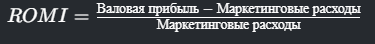

In [29]:
utm_purchase = df.query('event == "purchase"') \
    .groupby('utm_source', as_index = False) \
    .agg({'purchase_sum': 'sum'}) 
utm_purchase

,utm_source,purchase_sum
0,-,21449749.5
1,facebook_ads,12249901.0
2,google_ads,12868276.0
3,instagram_ads,14546969.0
4,referal,8837044.5
5,vk_ads,16389652.5
6,yandex-direct,13915368.0


Добавим значения для всех каналов привлечения.

In [30]:
utm_purchase.insert(2, "costs", [0, 8590498, 10534878, 8561626, 0, 9553531, 10491707], True)
romi = utm_purchase.query('costs > 0')
romi['romi'] = (romi.purchase_sum - romi.costs )/ romi.costs

C:\Users\Yuri\AppData\Local\Temp/ipykernel_14192/3686855203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  romi['romi'] = (romi.purchase_sum - romi.costs )/ romi.costs


In [31]:
romi.sort_values('romi', ascending = False)

,utm_source,purchase_sum,costs,romi
5,vk_ads,16389652.5,9553531,0.715560
3,instagram_ads,14546969.0,8561626,0.699090
1,facebook_ads,12249901.0,8590498,0.425983
6,yandex-direct,13915368.0,10491707,0.326321
2,google_ads,12868276.0,10534878,0.221493


**Ответ - самый высокий ROMI у канала vk_ads**